## Transfer Learning with PyTorch

In [27]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from pathlib import Path
from module import setup_data, engine
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from timeit import default_timer as timer
from helper_function import pytorch_plot_loss_curve
import random
from typing import List, Tuple
from PIL import Image
import requests

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Data preparation

In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_path = image_path / "train"
test_path = image_path / "test"

In [4]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
train_dataloader, test_dataloader, class_name = setup_data.create_dataloader(train_path = train_path, test_path = test_path,
    transform =  transform_image, batch_size = 32)

train_dataloader, test_dataloader, class_name

(<torch.utils.data.dataloader.DataLoader at 0x24f78a8bca0>,
 ['pizza', 'steak', 'sushi'])

In [6]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

In [7]:
# Set weight for transfer learning
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
model = torchvision.models.efficientnet_b0(weights = weight).to(device)

In [9]:
summary(model = model, 
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
summary(model = model, 
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_name)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True), 
    torch.nn.Linear(in_features = 1280, 
                    out_features = output_shape, 
                    bias = True)).to(device)

In [13]:
summary(model, 
        input_size = (32, 3, 224, 224),
        verbose = 0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

result = engine.start_training(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_function = loss_function,
                       epoch_number = 5,
                       device = device)

end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} second")

 20%|██        | 1/5 [00:28<01:54, 28.62s/it]

Epoch: 1 | train_loss: 1.1033 | train_accuracy: 0.3789 | test_loss: 0.8906 | test_accuracy: 0.5701


 40%|████      | 2/5 [00:56<01:25, 28.36s/it]

Epoch: 2 | train_loss: 0.9392 | train_accuracy: 0.6445 | test_loss: 0.8079 | test_accuracy: 0.7027


 60%|██████    | 3/5 [01:22<00:54, 27.13s/it]

Epoch: 3 | train_loss: 0.7611 | train_accuracy: 0.8945 | test_loss: 0.6431 | test_accuracy: 0.9072


 80%|████████  | 4/5 [01:49<00:26, 26.98s/it]

Epoch: 4 | train_loss: 0.7602 | train_accuracy: 0.6992 | test_loss: 0.5840 | test_accuracy: 0.8968


100%|██████████| 5/5 [02:16<00:00, 27.24s/it]

Epoch: 5 | train_loss: 0.6309 | train_accuracy: 0.8867 | test_loss: 0.6012 | test_accuracy: 0.9072
[INFO] Total training time: 136.192 second


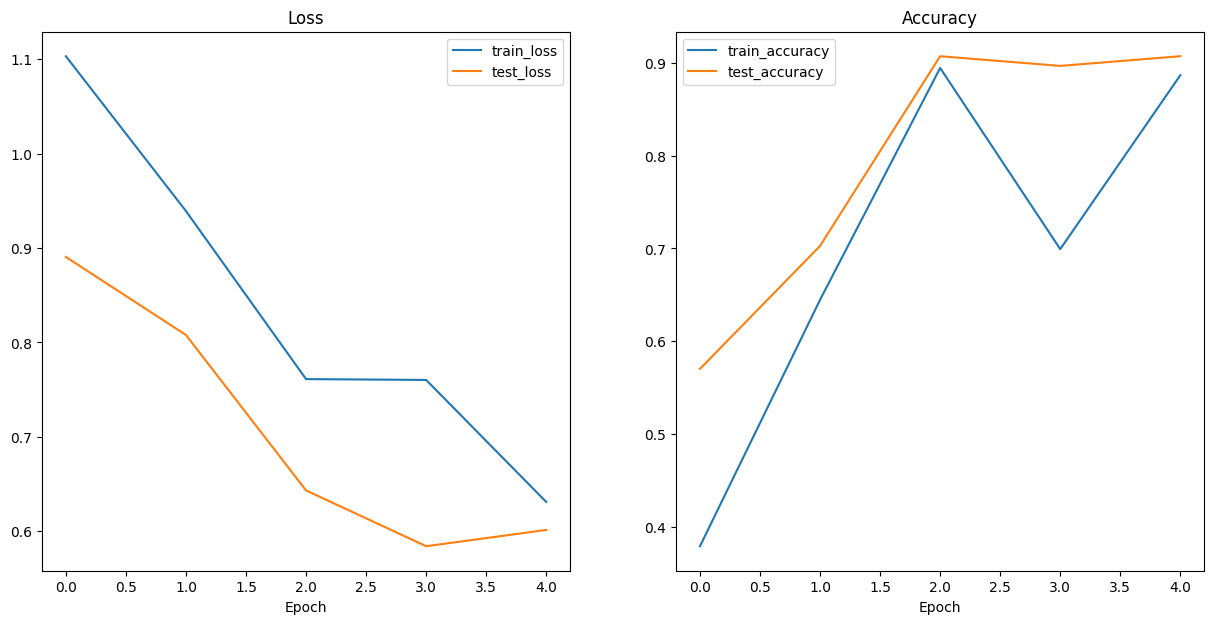

In [16]:
pytorch_plot_loss_curve(result)

In [25]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_name: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
    image = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(image).unsqueeze(dim = 0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_prob = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim = 1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_name[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis(False);

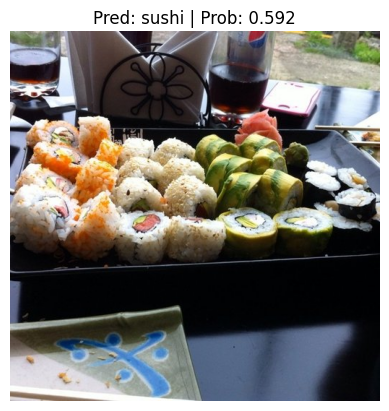

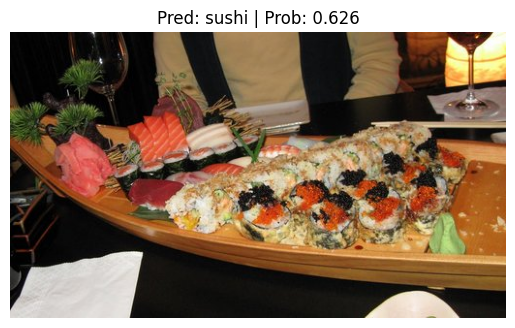

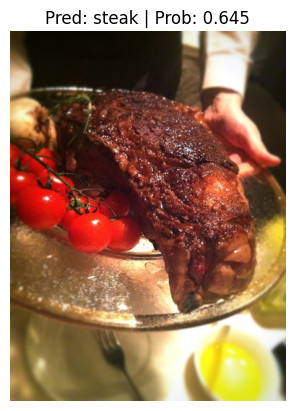

In [26]:
number_image_to_plot = 3
test_image_path_list = list(Path(test_path).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list, k = number_image_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model = model, image_path = image_path, class_name = class_name, 
                        image_size = (224, 224), device = device)

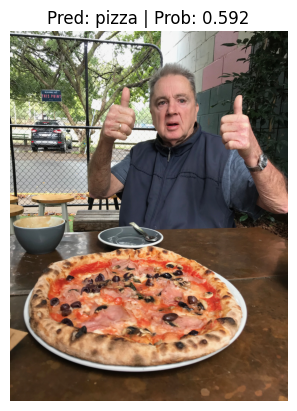

In [29]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

pred_and_plot_image(model = model, image_path = custom_image_path, class_name = class_name)